In [1]:
from environments import OneDCleanupEnv, CleanupRegion
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from agents import QAgent
import torch

2023-12-05 11:59:17,158	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"cuda available: {torch.cuda.is_available()}")
np.set_printoptions(threshold=np.inf)

cuda available: False


In [3]:

steps_per_episode = 1000
num_agents = 10
agent_ids = [str(i + 1) for i in range(num_agents)]

In [4]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [5]:
gamma = 0.999
epsilon = 1.0
epsilon_decay = 0.99995
epsilon_min = 0.1
lr = 0.0001
batch_size = 32

In [6]:
state_dim = 4
num_action_outputs = 1
action_size = 3

In [7]:
env = OneDCleanupEnv(agent_ids=agent_ids,
                     num_agents=num_agents,
                     area=area,
                     thresholdDepletion=thresholdDepletion,
                     thresholdRestoration=thresholdRestoration,
                     wasteSpawnProbability=wasteSpawnProbability,
                     appleRespawnProbability=appleRespawnProbability,
                     use_randomness=False,
                     dirt_multiplier=dirt_multiplier)
picker_q = QAgent(state_dim=state_dim,
                action_size=action_size,
                num_action_outputs=num_action_outputs,
                gamma=gamma,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                epsilon_min=epsilon_min,
                lr=lr,
                device=device,
                batch_size=batch_size,
                q_layers=[
                    (state_dim, 64),
                    (64, 32),
                    (32, action_size)
                ])
cleaner_q = QAgent(state_dim=state_dim,
                action_size=action_size,
                num_action_outputs=num_action_outputs,
                gamma=gamma,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                epsilon_min=epsilon_min,
                lr=lr,
                device=device,
                batch_size=batch_size,
                q_layers=[
                    (state_dim, 64),
                    (64, 32),
                    (32, action_size)
                ])

In [8]:
ending_ep_rewards = []
num_episodes = 100
steps_per_epsiode = 1000
verbose_episode = num_episodes - 1

In [9]:
max_reward = 0
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")

    states, info = env.reset()

    #print(f"info: {info}")

    prev_assignments = {id: env._agents[id].region for id in agent_ids}

    picker_has_stepped = False
    cleaner_has_stepped = False

    for step in tqdm(range(steps_per_epsiode)):
        num_apples, num_dirt, _, _ = states["coordinator"]
        agent_frequency_in_dirt = num_dirt / (num_apples + num_dirt)
        num_cleaner = round(num_agents * agent_frequency_in_dirt)
        num_picker = num_agents - num_cleaner
        assignments = env.get_greedy_assignments(num_picker, num_cleaner)
        directions = {}
        for agent_id in agent_ids:
            if assignments[agent_id] != prev_assignments[agent_id]:
                directions[agent_id] = 0
            elif assignments[agent_id] == CleanupRegion.APPLE:
                directions[agent_id] = picker_q.act(np.array(states[agent_id])).flatten()[0] - 1
            else:
                directions[agent_id] = cleaner_q.act(np.array(states[agent_id])).flatten()[0] - 1
        #print(f"actions: {actions}")
        actions = {agent_id: (assignments[agent_id], directions[agent_id]) for agent_id in agent_ids}
        next_states, rewards, dones, _, info = env.step(actions)

        for agent_id in agent_ids:
            if assignments[agent_id] != prev_assignments[agent_id]:
                continue
            elif assignments[agent_id] == CleanupRegion.APPLE:
                picker_q.step(np.array(states[agent_id]), actions[agent_id][1] + 1, rewards[agent_id], np.array(next_states[agent_id]))
                picker_has_stepped = True
            else:
                cleaner_q.step(np.array(states[agent_id]), actions[agent_id][1] + 1, rewards[agent_id], np.array(next_states[agent_id]))
                cleaner_has_stepped = True

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")

        states = next_states

        prev_assignments = assignments

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    print(f"========= End of Episode {episode} =========")

    ending_ep_rewards.append(ending_reward)

    if picker_has_stepped:
        picker_q.scheduler.step()
        picker_has_stepped = False
    if cleaner_has_stepped:
        cleaner_q.scheduler.step()
        cleaner_has_stepped = False

    if ending_reward > max_reward:
        max_reward = ending_reward

========= Episode 0 =========


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/gabeguralnick/git/social_reinforcement_learning/agents/q_agent.py:60: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(q_values, expected_q_values)
  1%|▏         | 13/1000 [00:00<00:15, 62.23it/s]

100%|█████████▉| 999/1000 [00:08<00:00, 119.10it/s]


ending reward: 47
========= End of Episode 0 =========
========= Episode 1 =========


 64%|██████▍   | 639/1000 [00:04<00:02, 132.49it/s]


KeyboardInterrupt: 

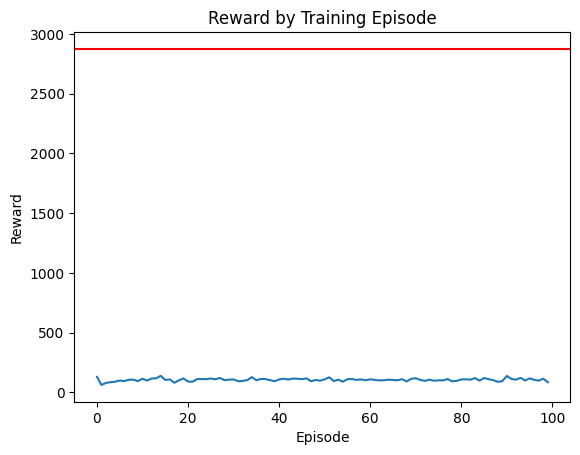

In [ ]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.axhline(y=2875.1, color='r', linestyle='-')
plt.show()

In [ ]:
num_episodes = 20
verbose_episode = num_episodes - 1
test_stats = []
picker_q.q_network.eval()
cleaner_q.q_network.eval()
for episode in range(num_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })
    
    print(f"========= Episode {episode} =========")

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #print(f"info: {info}")

    prev_assignments = {id: env._agents[id].region for id in agent_ids}

    for step in tqdm(range(steps_per_episode)):
        num_apples, num_dirt, _, _ = states["coordinator"]
        agent_frequency_in_dirt = num_dirt / (num_apples + num_dirt)
        num_cleaner = round(num_agents * agent_frequency_in_dirt)
        num_picker = num_agents - num_cleaner
        assignments = env.get_greedy_assignments(num_picker, num_cleaner)
        directions = {}
        for agent_id in agent_ids:
            if assignments[agent_id] != prev_assignments[agent_id]:
                directions[agent_id] = 0
            elif assignments[agent_id] == CleanupRegion.APPLE:
                directions[agent_id] = picker_q.act(np.array(states[agent_id])).flatten()[0] - 1
            else:
                directions[agent_id] = cleaner_q.act(np.array(states[agent_id])).flatten()[0] - 1
        #print(f"actions: {actions}")
        actions = {agent_id: (assignments[agent_id], directions[agent_id]) for agent_id in agent_ids}
        next_states, reward, dones, _, info = env.step(actions)
        
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])

        states = next_states
        prev_assignments = assignments

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = ending_reward

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")



========= Episode 0 =========


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [00:00<00:00, 1395.19it/s]


ending reward: 97
========= End of Episode 0 =========
========= Episode 1 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1456.26it/s]


ending reward: 105
========= End of Episode 1 =========
========= Episode 2 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1521.69it/s]


ending reward: 101
========= End of Episode 2 =========
========= Episode 3 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1522.21it/s]


ending reward: 115
========= End of Episode 3 =========
========= Episode 4 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1434.42it/s]


ending reward: 107
========= End of Episode 4 =========
========= Episode 5 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1515.64it/s]


ending reward: 108
========= End of Episode 5 =========
========= Episode 6 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1535.99it/s]


ending reward: 115
========= End of Episode 6 =========
========= Episode 7 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1518.89it/s]


ending reward: 106
========= End of Episode 7 =========
========= Episode 8 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1513.47it/s]


ending reward: 111
========= End of Episode 8 =========
========= Episode 9 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1529.81it/s]


ending reward: 101
========= End of Episode 9 =========
========= Episode 10 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1534.18it/s]


ending reward: 110
========= End of Episode 10 =========
========= Episode 11 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1528.71it/s]


ending reward: 112
========= End of Episode 11 =========
========= Episode 12 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1503.32it/s]


ending reward: 89
========= End of Episode 12 =========
========= Episode 13 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1529.07it/s]


ending reward: 109
========= End of Episode 13 =========
========= Episode 14 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1482.57it/s]


ending reward: 101
========= End of Episode 14 =========
========= Episode 15 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1313.28it/s]


ending reward: 106
========= End of Episode 15 =========
========= Episode 16 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1353.47it/s]


ending reward: 96
========= End of Episode 16 =========
========= Episode 17 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1510.88it/s]


ending reward: 102
========= End of Episode 17 =========
========= Episode 18 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1512.07it/s]


ending reward: 99
========= End of Episode 18 =========
========= Episode 19 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1464.21it/s]

ending reward: 115
========= End of Episode 19 =========


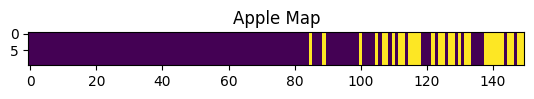

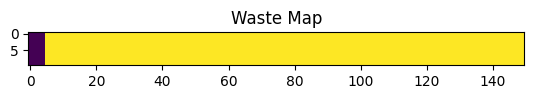

/Users/gabeguralnick/git/social_reinforcement_learning/environments/one_d_cleanup_env.py:474: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  apple_agent_map[np.where(apple_agent_map == id)] = 1


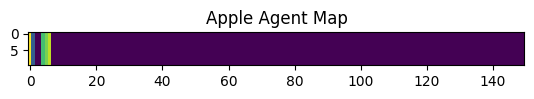

/Users/gabeguralnick/git/social_reinforcement_learning/environments/one_d_cleanup_env.py:484: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  waste_agent_map[np.where(waste_agent_map == id)] = 1


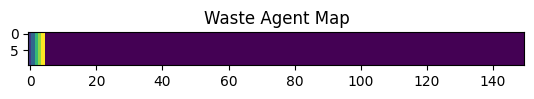

In [ ]:
env.render()

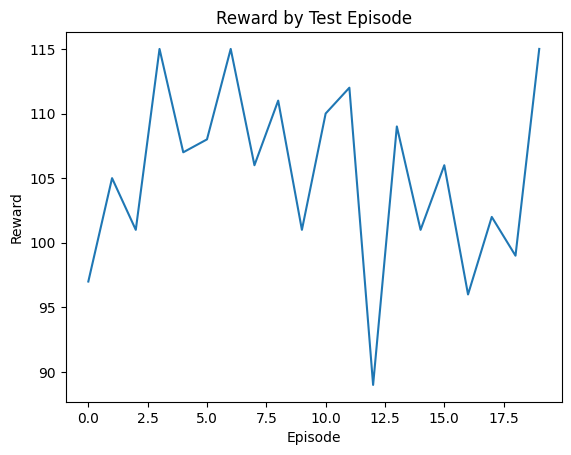

Average reward: 105.25


In [ ]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.show()
print(f"Average reward: {np.mean([stat['total_reward'] for stat in test_stats])}")

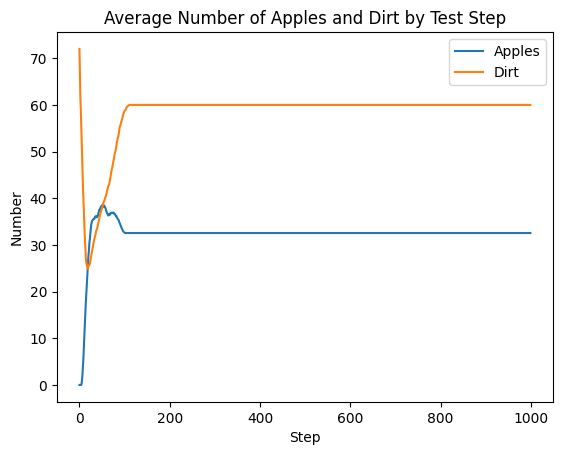

In [ ]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

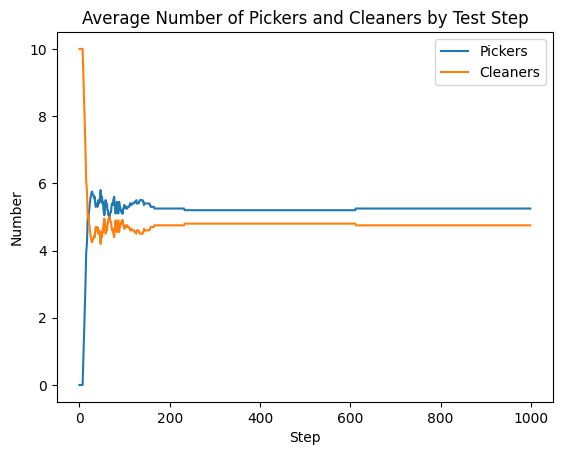

In [ ]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

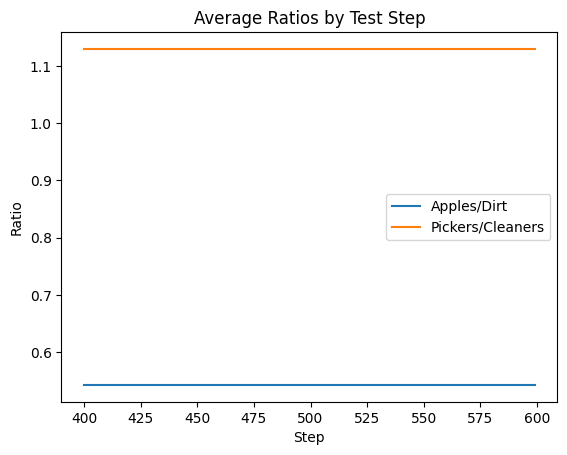

In [ ]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps[400:600], avg_apple_dirt_ratios[400:600], label="Apples/Dirt")
plt.plot(picker_cleaner_steps[400:600], avg_picker_cleaner_ratios[400:600], label="Pickers/Cleaners")
plt.legend()
plt.show()

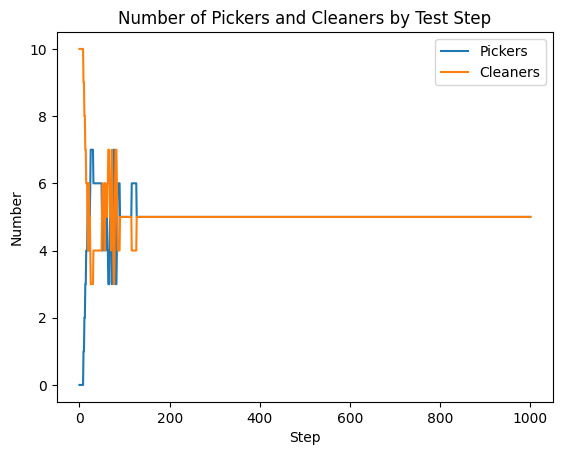

In [ ]:
plt.figure()
plt.title("Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
episode = test_stats[0]
plt.plot(episode['pickers'], label="Pickers")
plt.plot(episode['cleaners'], label="Cleaners")
plt.legend()
plt.show()